In [ ]:
#@markdown ##Run cell to mount your Google drive

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cp /content/drive/MyDrive/ode_model_simulation/pumpflux.py .
#
#from pumpflux import pumpvalues
#print(pumpvalues)

initial conditions: 7.4 10902209.84003497 495554.9927288622 14371094.789137004 0.0 1.6463621020892433e-16 



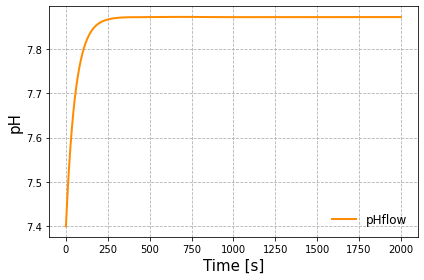

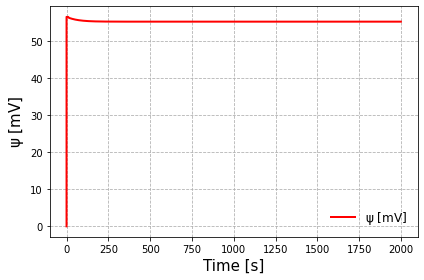

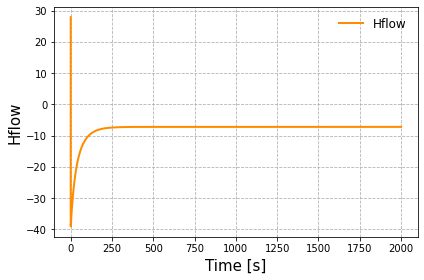

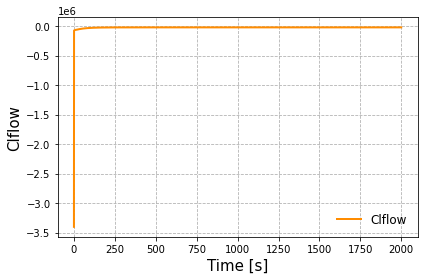

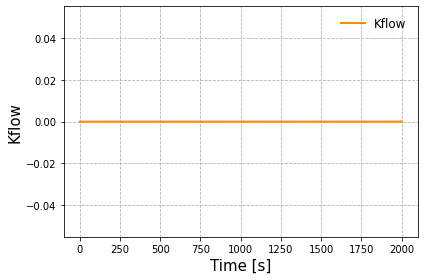

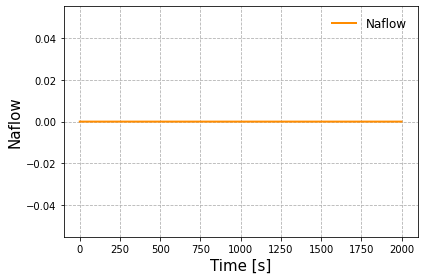

Simulation done!


In [ ]:
#@markdown #Run the ODE model simulation
#
#################################################################################################################
#                                                                                                               #
# This notebook for "ODE model simulation" is written by Ahmed Khalil for "a model of lysosomal acidification".  #
# The code is created based on the original ODE codes of Berkeley Madonna and Francesco Pasqualini.             # 
#                                                                                                               #
#################################################################################################################

import sys
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from pumpflux import pumpvalues


class ODEMODEL(object):    
    def __init__(self,STARTTIME=True, STOPTIME=True, DT=True, DTMAX=True, TOLERANCE=True, Pump_flux=True, B=True, Q=True):
        super(ODEMODEL, self).__init__()
        
        # Assigning simulation parameters:        
        # Standard Constants:
       
        self.mole=6.02e23#@param {type:"number"}      """ Avogadro's Number """
        self.RTF=25.69#@param {type:"number"}         """RT/F [mV]"""
        self.F=96485#@param {type:"number"}           """ Faraday's Constant """
        self.cap_0=1e-6#@param {type:"number"}        """ capacitance per unit area [Farad/cm^2]"""

        # METHOD STIFF
        self.STARTTIME=0#@param {type:"number"}
        self.STOPTIME=2000#@param {type:"number"}
        self.DT=0.02#@param {type:"number"}
        self.DTMAX=100#@param {type:"number"}
        self.TOLERANCE=1e-6#@param {type:"number"}
        
        # Donnan Particles [M]
        self.B=B 
        # enforce initial osmotic balance                                              
        self.Q=Q                                   
         
        # parameter list ()
        # vesicle shape variables (assumes spherical compartment)
        self.R=0.34#@param {type:"number"}            """ organelle radius [microns] """
        # initial volume [liters]
        self.initV=(4/3*np.pi*self.R**3*1e-12)/1000. 
        # surface area [cm^2]
        self.SA=4*np.pi*self.R**2*1e-8
        # total capacitance [Farad]
        self.cap=((self.cap_0*self.SA)/1000.)  
        
        # surface potentials parameters in mV:        
        self.psi_out=-50#@param {type:"number"}       """ outside leaflet [mV] """
        self.psi_in=0#@param {type:"number"}          """ inside leaflet [mV] """
        # set initial total membrane potential [mV]
        self.initpsi_total=0#@param {type:"number"}

        # cytosolic concentrations parameters
        self.pHbulk=7.2#@param {type:"number"}        """ for pH [pH units] """
        self.Kbulk=0.145#@param {type:"number"}       """ for K+ [M] """
        self.Clbulk=0.01#@param {type:"number"}       """ for Cl- [M] """
        self.Nabulk=0.01#@param {type:"number"}       """ for Na+ [M] """

        # luminal concentrations parameters
        self.initpH=7.4#@param {type:"number"}        """ pH [pH units] """
        self.initk= 0.005#@param {type:"number"}      """ K+ [M] """
        self.initcl=0.11#@param {type:"number"}       """ Cl- [M] """
        self.initna=0.145#@param {type:"number"}      """ Na+ [M] """
        self.initH=0.00#@param {type:"number"}        """ total H+ [M] """

        # kinetic parameters
        self.P = 6.0e-5 #@param {type:"number"}       """ H+ permeability """
        self.Pcl =   1.2e-5#@param {type:"number"}    """ Cl+ permeability """
        self.Pk= 0#@param {type:"number"}             """ K+ permeability """
        self.Pna= 0#@param {type:"number"}            """ Na+ permeability """
        self.Pw=0#@param {type:"number"}              """ Water permeability """
        self.N_VATP=300#@param {type:"number"}        """ Number of V-ATPases """
        self.N_CLC=5000#@param {type:"number"}        """ Number of ClC-7 antiporters """
        self.CLC_Cl=2#@param {type:"number"}          """ ClC-7 Cl- Stoichiometry """
        self.CLC_H=1#@param {type:"number"}           """ ClC-7 H+ Stoichiometry """
        self.Oc=0.291#@param {type:"number"}          """ Cytoplasmic Osmolarity [M] """
        self.oh=0.73#@param {type:"number"}           """ H+ Osmotic coefficient """
        self.ok=0.73#@param {type:"number"}           """ K+ Osmotic coefficient """
        self.ona=0.73#@param {type:"number"}          """ Na+ Osmotic coefficient """
        self.ocl=0.73#@param {type:"number"}          """ Cl- Osmotic coefficient """    

        # buffering capacity parameters in [mM/pH unit]
        self.beta=0.04#@param {type:"number"}
        # Flux values
        self.Pump_flux=Pump_flux



    # aux. fun
    @property
    def GetDIMsValues(self):

        grid_x = np.linspace(-300,300,31)   
        grid_y = np.linspace(0,9,46)        
        # get original flux values
        values = pumpvalues
        return grid_x, grid_y, values

    # aux. fun
    def GetMeshGrid(self, grid_x, grid_y):

        Gx, Gy = np.meshgrid(grid_x, grid_y)
        X_Interp = Gx.flatten()
        Y_Interp = Gy.flatten()
        return X_Interp, Y_Interp

    # aux. fun
    def ManageValues(self, values):

        # do slicing of sublists over values
        vsublists = [values[i:i+46] for i in range(0,len(values),46)]
        # convert it to numpy array
        vsublists = np.array(vsublists)
        # do transposing with reshaping to get the final values
        fvalues = vsublists.T.flatten()
        return fvalues
    
    @property
    def Interpolate(self):

        grid_x, grid_y, values = self.GetDIMsValues
        X_Interp, Y_Interp = self.GetMeshGrid(grid_x, grid_y)
        fvalues = self.ManageValues(values)
        self.Pump_flux = interpolate.interp2d(X_Interp, Y_Interp, fvalues, kind ='linear')
        return self.Pump_flux

    ##==========================================================================================================================
    ##==========================================================================================================================
    
    @property
    def InitConditions(self):

        pH  = self.initpH
        Ncl = self.initcl*self.initV*self.mole
        NK  = self.initk*self.initV*self.mole
        Nna = self.initna*self.initV*self.mole
        NH  = self.initH*self.initV*self.mole
        V   = self.initV
        return pH, Ncl, NK, Nna, NH, V


    def LuminalConcs(self, Ncl, V, NK, NH, Nna):

        Cl = Ncl/V/self.mole
        K = NK/V/self.mole
        H = NH/V/self.mole
        Na = Nna/V/self.mole
        return Cl, K, H, Na

 
    @property
    def GetMCytoSurfConcs(self):

        #Modified Cytoplasmic Surface Concentrations
        Cle = self.Clbulk*np.exp(self.psi_out/self.RTF)
        Ke  = self.Kbulk*np.exp(-self.psi_out/self.RTF)
        Nae = self.Nabulk*np.exp(-self.psi_out/self.RTF)
        pHe = (self.pHbulk+self.psi_out/(self.RTF*2.3))
        return Cle, Ke, Nae, pHe


    def GetMLuminalSurfConcs(self, Cl, K, Na, pH):
    
        #Modified Luminal Surface Concentrations
        Cli = Cl*np.exp((self.psi_in/self.RTF))
        Ki  = K*np.exp((-self.psi_in/self.RTF))
        Nai = Na*np.exp((-self.psi_in/self.RTF))
        pHi = (pH+self.psi_in/(self.RTF*2.3))
        return Cli, Ki, Nai, pHi


    @property
    def GetDonnanParticles(self):

        """
        it returns Donnan Particles [M] 
        """
        self.B = self.initk+self.initna+self.initH-self.initcl - self.cap/self.F/self.initV*(self.psi_in - self.psi_out) - self.initpsi_total*self.cap/self.F/self.initV
        return self.B


    @property
    def SetOsmoticBalance(self):
        
        """
        enforce initial osmotic balance
        """
        self.Q = self.initV*(self.Oc - (self.oh*10**(-self.initpH) + self.ok*self.initk + self.ona*self.initna + self.ocl*self.initcl))
        return self.Q


    def GetHpump(self,psi, pH):

        Hpump = self.N_VATP*self.Pump_flux(psi,pH)
        return Hpump


    def Getgg(self, psi):

        """
        it returns gg that allows treatment of singular terms for passive ion flux
        """  
    	
        if abs(psi) > .01:
            gg = psi/(1-np.exp(-psi/self.RTF))/self.RTF
            return gg
        else:
            gg = 1/(1 - (psi/self.RTF)/2 + (psi/self.RTF)**2/6. - (psi/self.RTF)**3/24. +(psi/self.RTF)**4/120.)
            return gg



    def GetggL(self, psi):

        """
        it returns gg that allows treatment of singular terms for passive ion flux
        """ 

        for p in psi: 
    	
            if abs(p) > .01:
                gg = p/(1-np.exp(-p/self.RTF))/self.RTF
                return gg
            else:
                gg = 1/(1 - (p/self.RTF)/2 + (p/self.RTF)**2/6. - (p/self.RTF)**3/24. +(p/self.RTF)**4/120.)
                return gg


 
    def GetCLC7(self, Cle, Cli, pHe, pHi, psi): 

        clc7f = (self.CLC_Cl+self.CLC_H)*psi + self.RTF*(2.3*(pHe - pHi) + self.CLC_Cl*np.log(Cle/Cli))
    
        G1 = -0.3*clc7f
        G3 = -1.5e-5*clc7f**3
        S = 0.5+0.5*np.tanh((clc7f+250)/75.)
        CLC7_rate = S*G1+(1-S)*G3
        CLC7 = self.N_CLC*CLC7_rate
        return CLC7 


    # passive flow functions:
    # 1.  
    def GetHflow(self, pHe, pHi, pH, psi, gg): 

        Hflow = self.P*self.SA*(10**(-pHe)*np.exp(-psi/self.RTF)-10**(-pHi))*gg*self.mole/1000.
        return Hflow

    # 2.
    def GetClflow(self, Cle, Cli, psi, gg):


        Clflow = self.Pcl*self.SA*( Cle-Cli*np.exp(-psi/self.RTF))*gg*self.mole/1000.
        return Clflow

    # 3.
    def GetKflow(self, Ke, psi, Ki, gg): ### i am here

        Kflow  = self.Pk*self.SA*(Ke*np.exp(-psi/self.RTF)-Ki)*gg*self.mole/1000.
        return Kflow

    # 4.
    def GetNaflow(self, Nae, psi, Nai, gg):

        Naflow = self.Pna*self.SA*(Nae*np.exp(-psi/self.RTF)-Nai)*gg*self.mole/1000. 
        return Naflow

    # 5.
    def GetJW(self, pH, K, Na, Cl, V):
    
        Jw = self.Pw*self.SA*(self.oh*10**(-pH) + self.ok*K + self.ona*Na + self.ocl*Cl + self.Q/V - self.Oc)
        return Jw



    # Time Dependent Quantitie (TDQ) functions:
    # 1.
    def Get_dpH_dt(self, Hpump, Hflow, CLC7, V):
        dpH_dt = ((-Hpump - Hflow -(self.CLC_H)*CLC7)/V/self.mole)/self.beta
        return dpH_dt

    # 2.
    def Get_dNcl_dt(self, Clflow, CLC7):

        dNcl_dt = Clflow - self.CLC_Cl*CLC7
        return dNcl_dt

    # 3.
    def Get_dNK_dt(self, Kflow):
        dNK_dt = Kflow
        return dNK_dt

    # 4.
    def Get_dNna_dt(self, Naflow):

        dNna_dt = Naflow
        return dNna_dt


    # 5.
    def Get_dNH_dt(self,Hpump, Hflow, CLC7):

        dNH_dt = Hpump + Hflow + (self.CLC_H)*CLC7
        return dNH_dt   

    # 6.
    def Get_dV_dt(self, Jw):
        dV_dt = Jw/(1000*55.)
        return dV_dt
    

    def GetTDP(self, list):

        """
        it returns time dependent parameters (TDP)
        """

        pH, Ncl = list[0],list[1]
        NK, Nna = list[2],list[3]
        NH, V   = list[4],list[5]
        return pH,Ncl,NK,Nna,NH,V
        

    def Getpsi(self, V, H, K, Na, Cl):
    
        psi = self.F*(V*(H+(K+Na)-Cl)-(self.B*self.initV))/self.cap
        return psi 
        
        
    def GetSolverConcs(self, MAT=np.array([])):
        
        """
        it returns concentrations matrices from the solver
        """  
        pH, Ncl = MAT[0, :], MAT[1, :]      
        NK, Nna = MAT[2, :], MAT[3, :]
        NH, V   = MAT[4, :], MAT[5, :] 
        return pH, Ncl, NK, Nna, NH, V

    
    def TDQ(self, t, y):

    	# get time dependent parameters
        pH, Ncl, NK, Nna, NH, V = self.GetTDP(y)
                     
        Cl, K, H, Na = self.LuminalConcs(Ncl, V, NK, NH, Nna)
        ## Modified Cytoplasmic Surface Concentrations
        Cle, Ke, Nae, pHe = self.GetMCytoSurfConcs 

        ## Modified Luminal Surface Concentrations
        Cli, Ki, Nai, pHi = self.GetMLuminalSurfConcs(Cl, K, Na, pH) ###  

        ## get psi
        psi = self.Getpsi(V, H, K, Na, Cl)
        # get Hpump
        Hpump = self.GetHpump(psi, pH) 
        # get CLC7      
        CLC7 = self.GetCLC7(Cle, Cli, pHe, pHi, psi)
        # treatment of singular terms for passive ion flux
        gg = self.Getgg(psi)
        # get Hflow        
        Hflow = self.GetHflow(pHe, pHi, pH, psi, gg)

        # get Clflow
        Clflow = self.GetClflow(Cle, Cli, psi, gg)
        Kflow = self.GetKflow(Ke, psi, Ki, gg)
        Naflow = self.GetNaflow(Nae, psi, Nai, gg)
        Jw = self.GetJW(pH, K, Na, Cl, V)      
 
        dpH_dt = self.Get_dpH_dt(Hpump, Hflow, CLC7, V) 
        dNcl_dt = self.Get_dNcl_dt(Clflow, CLC7)
        dNK_dt = self.Get_dNK_dt(Kflow)
        dNna_dt = self.Get_dNna_dt(Naflow)
        dNH_dt = self.Get_dNH_dt(Hpump, Hflow, CLC7)
        dV_dt = self.Get_dV_dt(Jw)
        return [dpH_dt, dNcl_dt, dNK_dt, dNna_dt, dNH_dt, dV_dt]
        
        
    def GetPlot(self, time, tdq, color=None, label=None, xlabel=True, ylabel=True, figname=None):
    
        plt.plot(time, tdq, linestyle='-', linewidth=2, color=color, label=label)        
        plt.grid(linestyle='--',alpha=2)
        plt.legend(loc="best", prop={'size':12}, frameon=False)        
        plt.xlabel(xlabel, fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        plt.tight_layout()
        plt.savefig(figname)
        plt.show()
        return 



# main function
def main():
    
    ODEMODELOBJ = ODEMODEL()
    Pump_flux = ODEMODELOBJ.Interpolate
    B = ODEMODELOBJ.GetDonnanParticles
    Q=ODEMODELOBJ.SetOsmoticBalance
    
    # set inital conditions
    pH, Ncl, NK, Nna, NH, V = ODEMODELOBJ.InitConditions  #
    print("initial conditions:", pH, Ncl, NK, Nna, NH, V, '\n')

    # time series
    TIMEINTERVAL = [ODEMODELOBJ.STARTTIME, ODEMODELOBJ.STOPTIME]
    time = np.arange(ODEMODELOBJ.STARTTIME, ODEMODELOBJ.STOPTIME,ODEMODELOBJ.DT)
        
    # solve ode using solve_ivp
    SOL = solve_ivp(fun=ODEMODELOBJ.TDQ, t_span=TIMEINTERVAL, y0=[pH, Ncl, NK, Nna, NH, V], t_eval=time, method='BDF') 
 
    pH, Ncl, NK, Nna, NH, V = ODEMODELOBJ.GetSolverConcs(SOL.y)    
    Cl, K, H, Na = ODEMODELOBJ.LuminalConcs(Ncl, V, NK, NH, Nna) 
    Cle, Ke, Nae, pHe = ODEMODELOBJ.GetMCytoSurfConcs
    Cli, Ki, Nai, pHi = ODEMODELOBJ.GetMLuminalSurfConcs(Cl, K, Na, pH)

    # get psi and psi (total)
    psi = ODEMODELOBJ.Getpsi(V, H, K, Na, Cl) 
    psi_total = psi + ODEMODELOBJ.psi_out-ODEMODELOBJ.psi_in
    # get CLC7      
    CLC7 = ODEMODELOBJ.GetCLC7(Cle, Cli, pHe, pHi, psi)
    # treatment of singular terms for passive ion flux
    gg = ODEMODELOBJ.GetggL(psi)
    
    # get flows:
    # 1. H-flow        
    Hflow = ODEMODELOBJ.GetHflow(pHe, pHi, pH, psi, gg)
    # 2. Cl-flow 
    Clflow = ODEMODELOBJ.GetClflow(Cle, Cli, psi, gg)
    # 3. K-flow
    Kflow = ODEMODELOBJ.GetKflow(Ke, psi, Ki, gg)
    # 4. Na-flow
    Naflow = ODEMODELOBJ.GetNaflow(Nae, psi, Nai, gg)
    # 5. Jw-flow
    Jw = ODEMODELOBJ.GetJW(pH, K, Na, Cl, V)      
 
  
    # get simulation plots: 
    # 1. pH flow
    ODEMODELOBJ.GetPlot(SOL.t, pH, color="darkorange", label="pHflow", xlabel="Time [s]", ylabel="pH", figname="pHflow")
    # 2.psi
    ODEMODELOBJ.GetPlot(SOL.t, psi_total, color="r", label=r"$\mathrm{\psi}$ [mV]", xlabel="Time [s]", ylabel=r"$\mathrm{\psi}$ [mV]", figname="psi")
    # 3. other flows:
    # a. Hflow
    ODEMODELOBJ.GetPlot(SOL.t, Hflow, color="darkorange", label="Hflow", xlabel="Time [s]", ylabel="Hflow", figname="Hflow")
    # b. Clflow
    ODEMODELOBJ.GetPlot(SOL.t, Clflow, color="darkorange", label="Clflow", xlabel="Time [s]", ylabel="Clflow", figname="Clflow")
    # c. Kflow
    ODEMODELOBJ.GetPlot(SOL.t, Kflow, color="darkorange", label="Kflow", xlabel="Time [s]", ylabel="Kflow", figname="Kflow")
    # d. Naflow
    ODEMODELOBJ.GetPlot(SOL.t, Naflow, color="darkorange", label="Naflow", xlabel="Time [s]", ylabel="Naflow", figname="Naflow")  
    
    print("Simulation done!")    


# run ODEMODEL simulation   
if __name__ == "__main__":
    main()